In [2]:

# Importing the necessary modules
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
import os
import cv2

In [8]:
# Loading CSV file containing labels
labels_df = pd.read_csv(r'D:\epoch_task\datasets\alphabet_labels.csv')

images = []
labels = []

for index, row in labels_df.iterrows():
    filename = row['file']
    label = row['label']
    img_path = os.path.join(r'D:\epoch_task\datasets\alphabet_images', filename)
    img = load_img(img_path, color_mode='grayscale', target_size=(28, 28))
    img_array = img_to_array(img)
    images.append(img_array)
    labels.append(label)

images = np.array(images) / 255.0  # Normalizing pixel values between 0 and 1
labels = np.array(labels)


# Encoding string labels to integers
label_Encoder = LabelEncoder()
labels = label_Encoder.fit_transform(labels)

# Checking for class imbalances
unique, counts = np.unique(labels, return_counts=True)
class_weights = {i: 1.0 / count for i, count in enumerate(counts)}

# Splitting data for training and testing 
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Reshaping data for the CNN input
x_train = x_train.reshape((-1, 28, 28, 1))
x_test = x_test.reshape((-1, 28, 28, 1))

In [11]:

# Creating a TF dataset
def create_dataset(images, labels, batch_size=32, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1024)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

train_dataset = create_dataset(x_train, y_train)
test_dataset = create_dataset(x_test, y_test, shuffle=False)

In [13]:
# Building the model for character identification
num_classes = len(np.unique(labels))

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.summary()

# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])  

# Learning rate scheduler
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                                 patience=3, min_lr=0.001)

# Training the model with the dataset
history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=test_dataset,
                    callbacks=[reduce_lr],
                    class_weight=class_weights)


# Evaluate on test data
test_loss, test_acc = model.evaluate(test_dataset)
print(f'Test accuracy: {test_acc}')


C:\Users\ethan\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 112,538 (439.60 KB)

 Trainable params: 112,538 (439.60 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
9312/9312 ━━━━━━━━━━━━━━━━━━━━ 117s 12ms/step - accuracy: 0.7427 - loss: 6.2006e-05 - val_accuracy: 0.9624 - val_loss: 0.1250 - learning_rate: 0.0010
Epoch 2/20
9312/9312 ━━━━━━━━━━━━━━━━━━━━ 96s 10ms/step - accuracy: 0.9525 - loss: 1.2034e-05 - val_accuracy: 0.9734 - val_loss: 0.0917 - learning_rate: 0.0010
Epoch 3/20
9312/9312 ━━━━━━━━━━━━━━━━━━━━ 108s 12ms/step - accuracy: 0.9650 - loss: 8.4918e-06 - val_accuracy: 0.9724 - val_loss: 0.0970 - learning_rate: 0.0010
Epoch 4/20
9312/9312 ━━━━━━━━━━━━━━━━━━━━ 97s 10ms/step - accuracy: 0.9701 - loss: 7.1609e-06 - val_accuracy: 0.9783 - val_loss: 0.0790 - learning_rate: 0.0010
Epoch 5/20
9312/9312 ━━━━━━━━━━━━━━━━━━━━ 94s 10ms/step - accuracy: 0.9737 - loss: 5.9844e-06 - val_accuracy: 0.9790 - val_loss: 0.0773 - learning_rate: 0.0010
Epoch 6/20
9312/9312 ━━━━━━━━━━━━━━━━━━━━ 96s 10ms/step - accuracy: 0.9755 - loss: 5.5501e-06 - val_accuracy: 0.9769 - val_loss: 0.0876 - learning_rate: 0.0010
Epoch 7/20
9312/9312 ━━━━━━━━━━━━━━━━━

In [14]:
import tensorflow as tf
import os

# Assuming your trained OCR model is in a variable called 'model'
# and your LabelEncoder is 'label_Encoder' from your notebook.

# --- Add this code to your notebook after you have trained the 'model' ---

# 1. Define the filename for your saved model
model_filename = 'ocr_character_recognition_model.h5'

# 2. Save the model
# This command saves the model's architecture, weights, and optimizer state.
print(f"Saving model to {model_filename}...")
model.save(model_filename)
print("Model saved successfully.")

# 3. (Optional) Load the model back to verify it works
print("\nLoading model back for verification...")
loaded_ocr_model = tf.keras.models.load_model(model_filename)
print("Model loaded successfully.")
loaded_ocr_model.summary()

# You can re-evaluate the loaded model on your test data to confirm
# it has the same performance.
print("\nEvaluating loaded model on test data...")
test_loss, test_acc = loaded_ocr_model.evaluate(test_dataset, verbose=0)
print(f'Loaded model test accuracy: {test_acc:.4f}')


# 4. Download the Model File (for Google Colab / Jupyter)
# This part of the code is specific to Google Colab.
# If you are running a local Jupyter server, the file will be
# in the same directory as your notebook.
try:
    from google.colab import files
    print(f"\nAttempting to download '{model_filename}'...")
    files.download(model_filename)
    print("If the download doesn't start, check your browser for a pop-up blocker.")
except ImportError:
    print(f"\nTo download the file, find '{model_filename}' in the file browser on the left side of your Jupyter interface and right-click to download.")



Saving model to ocr_character_recognition_model.h5...


Model saved successfully.

Loading model back for verification...
Model loaded successfully.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 112,540 (439.61 KB)

 Trainable params: 112,538 (439.60 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)


Evaluating loaded model on test data...
Loaded model test accuracy: 0.9854

To download the file, find 'ocr_character_recognition_model.h5' in the file browser on the left side of your Jupyter interface and right-click to download.


In [19]:
import tensorflow as tf
import os
import pickle


label_encoder_filename = 'ocr_label_encoder.pkl'


# 3. Save the Label Encoder using pickle
# We use 'wb' (write binary) mode to save the object.
print(f"Saving Label Encoder to {label_encoder_filename}...")
with open(label_encoder_filename, 'wb') as file:
    pickle.dump(label_Encoder, file)
print("Label Encoder saved successfully.")



Saving Label Encoder to ocr_label_encoder.pkl...
Label Encoder saved successfully.


In [21]:
# 3. (Optional) Load the model back to verify it works
print("\nLoading model back for verification...")
loaded_ocr_model = tf.keras.models.load_model(model_filename)
print("Model loaded successfully.")
loaded_ocr_model.summary()

# You can re-evaluate the loaded model on your test data to confirm
# it has the same performance.
print("\nEvaluating loaded model on test data...")
test_loss, test_acc = loaded_ocr_model.evaluate(test_dataset, verbose=0)
print(f'Loaded model test accuracy: {test_acc:.4f}')


Loading model back for verification...


Model loaded successfully.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 112,540 (439.61 KB)

 Trainable params: 112,538 (439.60 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)


Evaluating loaded model on test data...
Loaded model test accuracy: 0.9854


In [ ]:
# Verifying image paths
import os




# Loading and preprocessing a test image
def preprocess_test_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image at path {img_path} could not be loaded.")
    return img

# Slicing the test image into individual characters
def slice_image_into_characters(img, char_width=28, char_height=28):
    #L is a list of characters : 'X' if it identifies a letter and ' ' if it is just a whitespace
    L=[]
    characters = []
    h, w = img.shape
    last_x = 0
    for y in range(0, h, char_height):
        for x in range(0, w, char_width):
            char = img[y:y + char_height, x:x + char_width]
            if char.shape == (char_height, char_width):  # Ensure the character has the right dimensions
                if np.mean(char) < 5:  # Assuming very low mean intensity indicates a space
                    characters.append(' ')  # Represent space as a string ' '
                else:
                    char = char / 255.0  # Normalize pixel values
                    char = char.reshape((char_height, char_width, 1))
                    characters.append(char)
                last_x = x
                
    #Identifying what is a character and what isnt
    for char in characters:
        if isinstance(char, str):
            #print(char, end='')
            L.append(char)
        else:
            #print('X', end='')  # Placeholder for non-string characters
            L.append('X')
    
    return characters, L





# Process test images and spaces
all_characters_processed = []

for path in test_image_paths:
    try:
        img = preprocess_test_image(path)
        characters,L = slice_image_into_characters(img)
        all_characters_processed.extend(characters)
        
    except ValueError as e:
        print(e)

# Separate images and spaces
images_to_predict = []
for char in all_characters_processed:
    if isinstance(char, np.ndarray):
        images_to_predict.append(char)

# Convert images to numpy array
all_characters = np.array(images_to_predict)
statement=''
# Ensure the model is available as model
if all_characters.shape[0] > 0:
    # Make predictions
    predictions = model.predict(all_characters)

    # Map predictions to characters
    def get_character_from_prediction(prediction):
        classes = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz '  # Including space
        return classes[np.argmax(prediction)]

    predicted_characters = [get_character_from_prediction(pred) for pred in predictions]

    # Print the predicted characters
    
    
    printed_list=(''.join(predicted_characters))
   #Compare our list of characters without spaces to list L which determines where the whitespaces go
    index_L=index_pl=0
    while index_L <(len(L)):
       if L[index_L]==' ': 
           statement+=' '
           index_L+=1

       else: 
           statement+=printed_list[index_pl]
           index_L+=1
           index_pl+=1
else:
    print("No characters to predict.")

Dataset downloaded and extracted successfully.
Dataset shape: (160000, 6)

Class distribution:
sentiment
positive    80188
negative    79812
Name: count, dtype: int64

Cleaning text data...


C:\Users\ethan\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Model Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None

--- Training Model ---
Epoch 1/5
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 465s 115ms/step - accuracy: 0.7011 - loss: 0.5617 - val_accuracy: 0.7859 - val_loss: 0.4554
Epoch 2/5
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 457s 114ms/step - accuracy: 0.7858 - loss: 0.4604 - val_accuracy: 0.7914 - val_loss: 0.4492
Epoch 3/5
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 457s 114ms/step - accuracy: 0.7938 - loss: 0.4422 - val_accuracy: 0.7924 - val_loss: 0.4468
Epoch 4/5
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 463s 116ms/step - accuracy: 0.7999 - loss: 0.4348 - val_accuracy: 0.7933 - val_loss: 0.4464
Epoch 5/5
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 453s 113ms/step - accuracy: 0.8034 - loss: 0.4248 - val_accuracy: 0.7923 - val_loss: 0.4464

--- Plotting Results ---


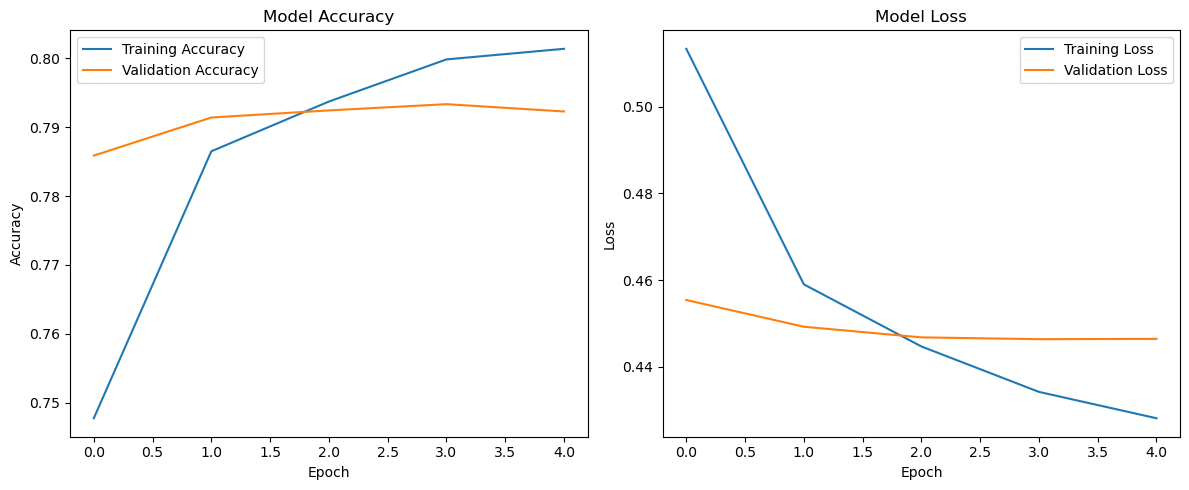

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step

Text: 'I enjoyed my journey on this flight.'
Predicted sentiment: positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step

Text: 'This is the worst flight experience of my life!'
Predicted sentiment: negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

Text: 'This is an amazing and beautiful day!'
Predicted sentiment: positive


In [10]:
#!/usr/bin/env python
# coding: utf-8

# ## Sentiment Analysis on the Stanford Sentiment140 Dataset

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import io
import zipfile
import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding

# --- 1. Load and Prepare Stanford Sentiment140 Data ---
# Download and unzip the dataset
url = 'http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip'
print("Downloading and extracting dataset...")
try:
    r = requests.get(url, stream=True)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()
    print("Dataset downloaded and extracted successfully.")
    
    # Load the data into a pandas DataFrame
    cols = ['sentiment', 'id', 'date', 'query', 'user', 'text']
    df = pd.read_csv('training.1600000.processed.noemoticon.csv', header=None, names=cols, encoding='latin-1')
except Exception as e:
    print(f"Failed to download or process the dataset. Error: {e}")
    exit()


# Preprocess the data
# The dataset uses 0 for negative and 4 for positive. We'll map 4 to 1.
df['sentiment'] = df['sentiment'].replace({0: 'negative', 4: 'positive'})

# Use a fraction of the data for faster training, you can increase this
df = df.sample(frac=0.1, random_state=42) 

print("Dataset shape:", df.shape)
print("\nClass distribution:")
print(df["sentiment"].value_counts())

# --- 2. Clean and Preprocess Text ---

def clean_text(text):
    text = text.lower()
    text = re.sub(r"@[a-z0-9_]+", "", text) # Remove mentions
    text = re.sub(r"https?://[a-z0-9./]+", "", text) # Remove URLs
    text = re.sub(r"[^a-z\s]", "", text) # Remove non-alphabetic characters
    text = re.sub(r"\s+", " ", text).strip() # Remove extra whitespace
    return text

print("\nCleaning text data...")
df['text'] = df['text'].apply(clean_text)

# Factorize labels ('negative' -> 0, 'positive' -> 1)
sentiment_label = df.sentiment.factorize()

# Tokenize the text data
tweet = df.text.values
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(tweet)

vocab_size = len(tokenizer.word_index) + 1
encoded_docs = tokenizer.texts_to_sequences(tweet)
padded_sequence = pad_sequences(encoded_docs, maxlen=200)


# --- 3. Build the LSTM Model (Same as your provided code) ---
embedding_vector_length = 32
model = Sequential() 
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid')) 

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
print("\nModel Summary:")
print(model.summary()) 

# --- 4. Train the Model ---
print("\n--- Training Model ---")
history = model.fit(padded_sequence, sentiment_label[0], validation_split=0.2, epochs=5, batch_size=32)

# --- 5. Plot Training History ---
print("\n--- Plotting Results ---")

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# --- 6. Prediction Function ---
def predict_sentiment(text):
    # Clean the input text using the same function
    cleaned_text = clean_text(text)
    tw = tokenizer.texts_to_sequences([cleaned_text])
    tw = pad_sequences(tw, maxlen=200)
    prediction = int(model.predict(tw).round().item())
    print(f"\nText: '{text}'")
    print(f"Predicted sentiment: {sentiment_label[1][prediction]}")

# --- 7. Test Predictions ---
test_sentence1 = "I enjoyed my journey on this flight."
predict_sentiment(test_sentence1)

test_sentence2 = "This is the worst flight experience of my life!"
predict_sentiment(test_sentence2)

test_sentence3 = "This is an amazing and beautiful day!"
predict_sentiment(test_sentence3)


In [12]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (32, 200, 32)          │     2,829,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (32, 200, 32)          │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (32, 50)               │        16,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (32, 50)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (32, 1)                │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,539,331 (32.57 MB)

 Trainable params: 2,846,443 (10.86 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,692,888 (21.72 MB)

In [14]:

# --- 4. Save the Trained Model and Tokenizer ---
print("\n--- Saving model and tokenizer ---")
model.save('sentiment_model_stanford.h5')
with open('tokenizer_stanford.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("Model and tokenizer saved successfully.")



--- Saving model and tokenizer ---
Model and tokenizer saved successfully.


In [13]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import io
import zipfile
import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding
from sklearn.metrics import accuracy_score, classification_report


In [9]:
import tensorflow as tf
import pickle
import os

# --- Define Paths ---
# Assumes the files are in the same directory as this script.
model_path = 'sentiment_model_stanford.h5'
tokenizer_path = 'tokenizer_stanford.pickle'

# --- Load Model and Tokenizer ---
try:
    # Load the trained TensorFlow/Keras model
    print(f"Loading model from: {model_path}")
    model = tf.keras.models.load_model(model_path)
    
    # Load the saved tokenizer object
    print(f"Loading tokenizer from: {tokenizer_path}")
    with open(tokenizer_path, 'rb') as handle:
        tokenizer = pickle.load(handle)
        
    print("\n✅ Model and tokenizer loaded successfully.")
    
    # You can now use the 'model' and 'tokenizer' variables for predictions.
    # For example, let's look at the model summary:
    print("\nModel Summary:")
    model.summary()

except FileNotFoundError:
    print("\nError: Could not find the model or tokenizer file.")
    print("Please make sure 'sentiment_model_stanford.h5' and 'tokenizer_stanford.pickle' are in the correct directory.")
except Exception as e:
    print(f"\nAn error occurred: {e}")


Loading model from: sentiment_model_stanford.h5
Loading tokenizer from: tokenizer_stanford.pickle

✅ Model and tokenizer loaded successfully.

Model Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (32, 200, 32)          │     2,829,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (32, 200, 32)          │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (32, 50)               │        16,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (32, 50)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (32, 1)                │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,846,445 (10.86 MB)

 Trainable params: 2,846,443 (10.86 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [15]:

def clean_text(text):
    text = text.lower()
    text = re.sub(r"@[a-z0-9_]+", "", text)
    text = re.sub(r"https?://[a-z0-9./]+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text
# ===================================================================
# PART 2: TEST THE SAVED MODEL ON YOUR CUSTOM DATASET
# ===================================================================

print("\n--- Testing model on your custom 'sentiment_analysis_dataset.csv' ---")

# --- 1. Load your custom dataset ---
try:
    df_custom =pd.read_csv(r'D:\epoch_task\datasets\sentiment_analysis_dataset.csv')
except FileNotFoundError:
    print("Error: 'sentiment_analysis_dataset.csv' not found.")
    print("Please upload your custom dataset to test the model.")
    exit()

# --- 2. Preprocess your custom dataset ---
# The model was trained on 'positive' and 'negative'. We will test on 'Happy' and 'Angry'.
df_custom = df_custom[df_custom['sentiment'] != 'Neutral']
# Map your labels to the model's expected format (0 for negative, 1 for positive)
label_map = {'Angry': 0, 'Happy': 1}
df_custom['sentiment_encoded'] = df_custom['sentiment'].map(label_map)

custom_sentences = df_custom['line'].tolist()
custom_labels = df_custom['sentiment_encoded'].values

# Clean the text using the SAME function
print("Cleaning your custom text data...")
cleaned_custom_sentences = [clean_text(s) for s in custom_sentences]

# --- 3. Use the SAVED tokenizer to process your data ---
# This ensures the word-to-number mapping is consistent.
test_sequences = tokenizer.texts_to_sequences(cleaned_custom_sentences)
test_padded_sequence = pad_sequences(test_sequences, maxlen=200)

# --- 4. Make Predictions and Evaluate ---
predictions = model.predict(test_padded_sequence).round().astype(int)

accuracy = accuracy_score(custom_labels, predictions)
report = classification_report(custom_labels, predictions, target_names=['Angry (Predicted)', 'Happy (Predicted)'])

print("\n--- Test Results on Your Dataset ---")
print(f"Accuracy on 'sentiment_analysis_dataset.csv': {accuracy:.4f}")
print("\nClassification Report:")
print(report)



--- Testing model on your custom 'sentiment_analysis_dataset.csv' ---
Cleaning your custom text data...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

--- Test Results on Your Dataset ---
Accuracy on 'sentiment_analysis_dataset.csv': 0.9000

Classification Report:
                   precision    recall  f1-score   support

Angry (Predicted)       1.00      0.80      0.89        10
Happy (Predicted)       0.83      1.00      0.91        10

         accuracy                           0.90        20
        macro avg       0.92      0.90      0.90        20
     weighted avg       0.92      0.90      0.90        20

